In [1]:
import os
import umap
import json
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from copy import deepcopy
from pylab import rcParams
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

In [2]:
np.random.seed(1341)
torch.manual_seed(1341)
torch.cuda.manual_seed(1341)

In [3]:
ST5 = pd.read_excel(
    "SupplementaryTable5.xlsx", index_col=0, engine="openpyxl"
)

In [4]:
out = ""
for a in ST5["gRNA"]:
    for i in range(1, 7):
        out += a+" "+str(i)+"\n"

In [5]:
with open("config.json", "r") as ih:
    cfg = json.loads(ih.read())

In [6]:
GENESDIR = "THISREPO/results/Chr22/DeepHF/WT/chr22_genes/".replace(
    "THISREPO", cfg["THISREPO"]
)
CASOFFCONFIGS = "THISREPO/results/Chr22/OT_1000/chr22_casoffinder_configs/".replace(
    "THISREPO", cfg["THISREPO"]
)
GRNADIR = "THISREPO/results/Chr22/OT_1000/chr22_grnas/".replace(
    "THISREPO", cfg["THISREPO"]
)
ORDDIR = "THISREPO/results/Chr22/OT_1000/chr22_ordered/".replace(
    "THISREPO", cfg["THISREPO"]
)

In [7]:
if not op.exists(CASOFFCONFIGS):
    os.makedirs(CASOFFCONFIGS)
if not op.exists(GRNADIR):
    os.makedirs(GRNADIR)
if not op.exists(ORDDIR):
    os.makedirs(ORDDIR)

In [8]:
TEMPLATE = GENESDIR+"GENE\nNNNNNNNNNNNNNNNNNNNNNGG\n"+out
COMMAND = "CASOFFINDERPATH CONFIG G OUTPUT".replace(
    "CASOFFINDERPATH", cfg["CASOFFINDERPATH"]
)
ANNOTATION = cfg["Chr22_annotation"]

In [9]:
annotation = pd.read_csv(ANNOTATION, header=1)[["Start", "Stop", "Gene symbol"]]
annotation = list(
    zip(
        annotation["Start"].values, annotation["Stop"].values, 
        annotation["Gene symbol"].values
    )
)
annotation = sorted(annotation, key=lambda x: x[0])

In [10]:
script = open("run_casoffinder_Figure6.sh", "w")
script.write("#!/bin/sh\n\n")
for _, _, gene in tqdm(annotation):
    with open(op.join(CASOFFCONFIGS, gene+".txt"), "w") as oh:
        oh.write(TEMPLATE.replace("GENE", gene+".fa"))
    script.write(
        COMMAND.replace(
            "CONFIG", op.join(CASOFFCONFIGS, gene+".txt")
        ).replace(
            "OUTPUT", op.join(GRNADIR, gene+".tsv")
        )+"\n"
    )
script.close()

100%|██████████| 1186/1186 [00:00<00:00, 5451.87it/s]


###### Now run run_casoffinder_Figure6.sh

In [11]:
u = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=0, cut_at_end=0)
transformer = transforms.Compose(
    [
        u, ToTensor(cudap=True)
    ]
)

In [12]:
w_encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
w_model = DKL(w_encoder, [1,5*32]).cuda().eval()
w_model.load_state_dict(torch.load("../models/JostEtAl/model59.ptch"))
w_model = w_model.eval()

In [13]:
data = np.array(
    [a for a in os.walk(GRNADIR)][0][2]
)
sizes = np.array(
    [op.getsize(op.join(GRNADIR, a)) for a in data]
)

In [14]:
genes = {a[2]: [] for a in annotation}
for i,a in enumerate(data):
    try:
        current_df = pd.read_csv(op.join(GRNADIR, a), sep="\t", header=None).dropna()
        current_df = current_df[current_df[5] > 0]
        current_df = current_df[current_df[3].apply(lambda x: len(x) == 23 and " " not in x)]
        current_df[6] = [a]*current_df.shape[0]
        print(i, current_df.shape)
    except Exception as e:
        print(e)
    else:
        try:
            tds = JostEtAlDataset(
                current_df, np.arange(current_df.shape[0]), transformer,
                genome_column=3, sgRNA_column=0,
                label_column=5
            )
            tld = DataLoader(tds, shuffle=False, batch_size=256)
            tb_w_oa = []
            tb_w_va = []
            tb_w_ra = []
            for transformed_batch, _ in tqdm(tld):
                tb_w_o = w_encoder(transformed_batch)[0].cpu().data.numpy()
                tb_w_ra.extend(tb_w_o)
                tb_w = w_model(transformed_batch)
                tb_w_o = w_model.likelihood(
                    tb_w[0]
                ).mean.mean(0).cpu().data.numpy()
                tb_w_v = w_model.likelihood(
                    tb_w[0]
                ).variance.mean(0).cpu().data.numpy()
                tb_w_oa.extend(tb_w_o)
                tb_w_va.extend(tb_w_v)
            current_df[7] = tb_w_oa
            current_df[8] = tb_w_va
            current_df = current_df.sort_values(by=7, ascending=False)
            current_df.to_csv(
                op.join(
                    op.join(ORDDIR, a)
                ), sep="\t", header=None
            )
        except Exception as e:
            print(e)

  0%|          | 0/1 [00:00<?, ?it/s]

0 (113, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1 (356, 7)
2 (11, 7)
3 (323, 7)


 25%|██▌       | 1/4 [00:00<00:00,  8.60it/s]

4 (10, 7)
5 (956, 7)


 11%|█         | 1/9 [00:00<00:00,  8.91it/s]

6 (58, 7)
7 (2174, 7)


  3%|▎         | 1/30 [00:00<00:03,  9.16it/s]

8 (38, 7)
9 (7533, 7)


 14%|█▍        | 1/7 [00:00<00:00,  9.20it/s]

10 (6, 7)
11 (1629, 7)


  9%|▉         | 1/11 [00:00<00:01,  9.24it/s]

12 (125, 7)
13 (2568, 7)


  5%|▍         | 1/21 [00:00<00:02,  9.13it/s]

14 (5295, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

15 (26, 7)
16 (2222, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

17 (14, 7)
18 (482, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]

19 (368, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.51it/s]

20 (542, 7)


  0%|          | 0/21 [00:00<?, ?it/s]

21 (119, 7)
22 (5359, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

23 (45, 7)
24 (5, 7)
25 (1905, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

26 (17, 7)
27 (12, 7)
28 (496, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.99it/s]

29 (2886, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.94it/s]

30 (2581, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

31 (1, 7)
32 (49, 7)
33 (1031, 7)


  0%|          | 0/36 [00:00<?, ?it/s]

34 (6, 7)
35 (1, 7)
36 (1, 7)
37 (4, 7)
38 (16, 7)
39 (8988, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

40 (1, 7)
41 (18, 7)
No columns to parse from file
43 (486, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.15it/s]

44 (10, 7)
45 (1488, 7)


 11%|█         | 1/9 [00:00<00:01,  5.98it/s]

46 (2065, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.42it/s]

47 (14, 7)
48 (305, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.40it/s]

49 (622, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

50 (214, 7)
51 (46, 7)
52 (1110, 7)


 20%|██        | 1/5 [00:00<00:00,  6.16it/s]

53 (1076, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

54 (113, 7)
55 (82, 7)
56 (6, 7)
57 (575, 7)


 11%|█         | 1/9 [00:00<00:01,  5.91it/s]

58 (2198, 7)


  0%|          | 0/34 [00:00<?, ?it/s]

59 (88, 7)
60 (8568, 7)


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

61 (279, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

62 (36, 7)
63 (193, 7)
64 (79, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

65 (130, 7)
66 (987, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.11it/s]

67 (743, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.26it/s]

68 (12, 7)
No columns to parse from file
70 (530, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

71 (9, 7)
72 (87, 7)
73 (19, 7)
74 (140, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

75 (22, 7)
76 (2560, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

No columns to parse from file
78 (54, 7)
79 (1051, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

80 (16, 7)
81 (25, 7)
82 (1064, 7)


 20%|██        | 1/5 [00:00<00:00,  6.28it/s]

83 (1048, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

No columns to parse from file
85 (1, 7)
86 (33, 7)
87 (660, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

88 (6, 7)
89 (43, 7)
90 (284, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.22it/s]

91 (689, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]

92 (325, 7)


  0%|          | 0/21 [00:00<?, ?it/s]

93 (37, 7)
94 (21, 7)
95 (16, 7)
96 (5156, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

97 (21, 7)
98 (22, 7)
99 (591, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.07it/s]

100 (680, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

101 (20, 7)
102 (540, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.18it/s]

103 (681, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.94it/s]

104 (3642, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

105 (119, 7)
106 (114, 7)
107 (1, 7)


  8%|▊         | 1/12 [00:00<00:01,  6.16it/s]

108 (2888, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

109 (46, 7)
110 (108, 7)
111 (3, 7)
112 (214, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

113 (1, 7)
114 (1, 7)
115 (50, 7)
116 (1, 7)
117 (448, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.16it/s]

118 (852, 7)


  4%|▍         | 1/25 [00:00<00:03,  6.36it/s]

119 (4, 7)
120 (6260, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

121 (29, 7)
122 (75, 7)
123 (65, 7)
124 (3, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

125 (11, 7)
126 (3613, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

127 (41, 7)
128 (3461, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

129 (33, 7)
130 (426, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.15it/s]

131 (3, 7)
132 (955, 7)


 10%|█         | 1/10 [00:00<00:01,  6.35it/s]

133 (2340, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.35it/s]

134 (924, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

135 (244, 7)
136 (7, 7)
137 (81, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

138 (54, 7)
139 (4342, 7)


  0%|          | 0/18 [00:00<?, ?it/s]

140 (1, 7)
141 (4488, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

142 (6, 7)
143 (26, 7)
144 (210, 7)


 11%|█         | 1/9 [00:00<00:01,  5.92it/s]

145 (2128, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]

146 (456, 7)


 20%|██        | 1/5 [00:00<00:00,  5.85it/s]

147 (1065, 7)


  6%|▌         | 1/17 [00:00<00:03,  5.21it/s]

148 (4263, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.14it/s]

149 (494, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

150 (341, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

151 (2, 7)
152 (83, 7)
No columns to parse from file
154 (30, 7)
155 (61, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

156 (47, 7)
157 (38, 7)
158 (8, 7)
159 (43, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

160 (89, 7)
161 (1297, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

162 (2, 7)
No columns to parse from file
164 (926, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.41it/s]

165 (324, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.66it/s]

166 (756, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

167 (17, 7)
168 (2, 7)
169 (87, 7)
170 (24, 7)
171 (103, 7)


  6%|▌         | 1/17 [00:00<00:02,  5.97it/s]

172 (4276, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

No columns to parse from file
174 (214, 7)
175 (1502, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

176 (48, 7)
177 (621, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

178 (1, 7)
179 (1, 7)
180 (51, 7)
181 (1578, 7)


 10%|█         | 1/10 [00:00<00:01,  6.18it/s]

182 (2518, 7)


  0%|          | 0/56 [00:00<?, ?it/s]

183 (2, 7)
184 (14216, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

185 (37, 7)
186 (26, 7)
187 (497, 7)


  7%|▋         | 1/15 [00:00<00:02,  6.33it/s]

188 (3756, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

189 (192, 7)
190 (2, 7)
191 (4244, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

192 (179, 7)
193 (1853, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.81it/s]

194 (1673, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

195 (156, 7)
196 (6, 7)
197 (2208, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

198 (36, 7)
199 (5, 7)
200 (95, 7)
201 (779, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

202 (36, 7)
203 (31, 7)
204 (709, 7)


  0%|          | 0/40 [00:00<?, ?it/s]

205 (2, 7)
206 (19, 7)
207 (10069, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

208 (78, 7)
209 (2248, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]

210 (491, 7)


  0%|          | 0/29 [00:00<?, ?it/s]

No columns to parse from file
212 (2, 7)
213 (1, 7)
214 (5, 7)
215 (7397, 7)


  0%|          | 0/47 [00:00<?, ?it/s]

216 (13, 7)
217 (37, 7)
218 (8, 7)
219 (11979, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

220 (146, 7)
221 (835, 7)


  0%|          | 0/51 [00:00<?, ?it/s]

222 (7, 7)
223 (3, 7)
224 (12902, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

225 (37, 7)
226 (293, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]

227 (417, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

228 (17, 7)
229 (26, 7)
230 (22, 7)
231 (816, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

232 (97, 7)
233 (962, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.45it/s]

234 (10, 7)
235 (823, 7)


  1%|          | 1/101 [00:00<00:15,  6.49it/s]

236 (25731, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

237 (2, 7)
238 (598, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.79it/s]

239 (1763, 7)


  0%|          | 0/27 [00:00<?, ?it/s]

240 (124, 7)
241 (6908, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

242 (3, 7)
243 (947, 7)


  5%|▌         | 1/20 [00:00<00:03,  5.99it/s]

244 (4927, 7)


100%|██████████| 1/1 [00:00<00:00, 25.55it/s]

245 (125, 7)
246 (38, 7)
247 (38, 7)



  0%|          | 0/28 [00:00<?, ?it/s]

248 (1466, 7)
249 (35, 7)
250 (20, 7)
251 (1, 7)
252 (7112, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

253 (83, 7)
254 (64, 7)
255 (28, 7)
256 (1117, 7)


  1%|          | 1/121 [00:00<00:20,  5.92it/s]

257 (30945, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

No columns to parse from file
259 (39, 7)
260 (42, 7)
261 (815, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

262 (8, 7)
263 (14, 7)
264 (1185, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.75it/s]

265 (356, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.80it/s]

266 (1509, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.00it/s]

267 (863, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.23it/s]

268 (1015, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

269 (56, 7)
270 (30, 7)
271 (147, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

272 (135, 7)
273 (2, 7)
274 (147, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.04it/s]

275 (678, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

276 (264, 7)
277 (14, 7)


 11%|█         | 1/9 [00:00<00:01,  6.06it/s]

278 (2115, 7)


  0%|          | 0/37 [00:00<?, ?it/s]

279 (18, 7)
280 (9417, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.23it/s]

281 (1886, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

282 (260, 7)
283 (319, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

284 (61, 7)
285 (687, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

286 (47, 7)
287 (20, 7)
288 (1, 7)
289 (425, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

290 (198, 7)
291 (22, 7)
292 (176, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

293 (43, 7)
294 (2, 7)
295 (692, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.89it/s]

296 (2668, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.93it/s]

297 (1581, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

298 (9, 7)
299 (8, 7)
300 (1345, 7)


 11%|█         | 1/9 [00:00<00:01,  5.97it/s]

301 (2300, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

302 (94, 7)
303 (2415, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

304 (210, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

305 (1622, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

306 (235, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

307 (4288, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

308 (2292, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

309 (10, 7)
310 (292, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

311 (33, 7)
312 (19, 7)
No columns to parse from file
314 (133, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

315 (116, 7)
316 (1865, 7)


  0%|          | 0/31 [00:00<?, ?it/s]

317 (19, 7)
318 (7906, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.80it/s]

319 (817, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]

320 (473, 7)


  6%|▌         | 1/18 [00:00<00:03,  5.13it/s]

321 (4555, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.57it/s]

322 (1011, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

323 (1622, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

324 (173, 7)
325 (186, 7)


  0%|          | 0/25 [00:00<?, ?it/s]

326 (27, 7)
327 (6192, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.37it/s]

328 (3833, 7)


 11%|█         | 1/9 [00:00<00:01,  6.01it/s]

329 (2156, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

330 (20, 7)
331 (450, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.01it/s]

332 (549, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.06it/s]

333 (868, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]

334 (504, 7)


  4%|▍         | 1/26 [00:00<00:04,  6.08it/s]

335 (1, 7)
336 (6451, 7)


  1%|▏         | 1/72 [00:00<00:12,  5.81it/s]

337 (18268, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.30it/s]

338 (924, 7)


  0%|          | 0/40 [00:00<?, ?it/s]

339 (153, 7)
340 (10041, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.41it/s]

341 (744, 7)


 10%|█         | 1/10 [00:00<00:01,  6.37it/s]

342 (2319, 7)


  0%|          | 0/81 [00:00<?, ?it/s]

343 (93, 7)
344 (20554, 7)


100%|██████████| 1/1 [00:00<00:00, 24.87it/s]

No columns to parse from file
346 (195, 7)
347 (44, 7)
348 (1548, 7)



 33%|███▎      | 1/3 [00:00<00:00,  6.21it/s]

349 (657, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

350 (173, 7)
351 (1040, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]

No columns to parse from file
353 (356, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.31it/s]

354 (17, 7)
355 (756, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.31it/s]

356 (4, 7)
No columns to parse from file
358 (4531, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

359 (14, 7)
360 (10, 7)
361 (466, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]

362 (464, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.38it/s]

363 (685, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.32it/s]

364 (560, 7)


  1%|          | 1/145 [00:00<00:23,  6.11it/s]

365 (37020, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]

366 (333, 7)


  0%|          | 0/67 [00:00<?, ?it/s]

367 (3, 7)
368 (17136, 7)


  0%|          | 0/24 [00:00<?, ?it/s]

369 (4, 7)
370 (95, 7)
371 (5906, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

372 (146, 7)
373 (5, 7)
374 (249, 7)


  4%|▍         | 1/25 [00:00<00:03,  6.25it/s]

375 (6180, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

376 (127, 7)
377 (11, 7)
378 (194, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]

379 (317, 7)


  6%|▌         | 1/17 [00:00<00:02,  6.27it/s]

380 (4181, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.48it/s]

381 (803, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.48it/s]

382 (3, 7)
383 (2610, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

384 (36, 7)
385 (10, 7)
386 (14, 7)
387 (249, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

388 (11, 7)
389 (49, 7)
390 (14, 7)
391 (1026, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
393 (2, 7)
394 (233, 7)
No columns to parse from file
396 (377, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.26it/s]

397 (951, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

398 (14, 7)
399 (220, 7)
400 (11, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]

401 (339, 7)


  5%|▌         | 1/20 [00:00<00:02,  6.48it/s]

402 (14, 7)
403 (4974, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.50it/s]

404 (7, 7)
405 (886, 7)


 20%|██        | 1/5 [00:00<00:00,  6.09it/s]

406 (1165, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

407 (31, 7)
408 (2903, 7)


  5%|▌         | 1/20 [00:00<00:02,  6.49it/s]

409 (5046, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.50it/s]

410 (1604, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

411 (55, 7)
412 (8, 7)
413 (2455, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.49it/s]

414 (625, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.51it/s]

415 (1775, 7)


  0%|          | 0/20 [00:00<?, ?it/s]

416 (33, 7)
417 (4962, 7)


100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

418 (307, 7)



 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

419 (1330, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.21it/s]

420 (1, 7)
421 (1507, 7)


 11%|█         | 1/9 [00:00<00:01,  6.40it/s]

422 (2066, 7)


 20%|██        | 1/5 [00:00<00:00,  6.52it/s]

423 (1224, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

424 (3, 7)
425 (21, 7)
No columns to parse from file
427 (1349, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.33it/s]

428 (13, 7)
429 (1789, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

430 (181, 7)
431 (3049, 7)


  8%|▊         | 1/13 [00:00<00:01,  6.51it/s]

432 (3176, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.51it/s]

433 (788, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.37it/s]

434 (3868, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.41it/s]

435 (1396, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

436 (43, 7)
437 (20, 7)
No columns to parse from file
No columns to parse from file
440 (8, 7)
441 (142, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

442 (23, 7)
443 (52, 7)
444 (2073, 7)


 20%|██        | 1/5 [00:00<00:00,  6.30it/s]

445 (1127, 7)


  3%|▎         | 1/31 [00:00<00:04,  6.40it/s]

446 (5, 7)
447 (7911, 7)


  0%|          | 0/27 [00:00<?, ?it/s]

448 (233, 7)
449 (1, 7)
450 (6785, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

451 (89, 7)
452 (14, 7)
453 (419, 7)


 20%|██        | 1/5 [00:00<00:00,  6.52it/s]

454 (1097, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]

No columns to parse from file
456 (456, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

457 (147, 7)
458 (57, 7)
459 (5, 7)
460 (313, 7)


  7%|▋         | 1/14 [00:00<00:02,  6.48it/s]

461 (13, 7)
462 (3397, 7)


  7%|▋         | 1/14 [00:00<00:02,  6.49it/s]

463 (3422, 7)


  5%|▌         | 1/19 [00:00<00:02,  6.49it/s]

464 (4749, 7)


100%|██████████| 1/1 [00:00<00:00, 53.00it/s]

465 (82, 7)
No columns to parse from file
467 (2, 7)
468 (106, 7)
469 (8, 7)



 33%|███▎      | 1/3 [00:00<00:00,  6.35it/s]

470 (607, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

471 (6, 7)
472 (1362, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.39it/s]

473 (1885, 7)


 20%|██        | 1/5 [00:00<00:00,  6.37it/s]

474 (1053, 7)


  0%|          | 0/23 [00:00<?, ?it/s]

475 (28, 7)
476 (13, 7)
477 (5855, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]

478 (500, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.36it/s]

479 (11, 7)
480 (1489, 7)


  0%|          | 0/56 [00:00<?, ?it/s]

481 (8, 7)
482 (14232, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

483 (157, 7)
484 (4244, 7)


  7%|▋         | 1/14 [00:00<00:02,  6.37it/s]

485 (3389, 7)


  7%|▋         | 1/14 [00:00<00:02,  6.38it/s]

486 (3502, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

487 (188, 7)
488 (58, 7)
489 (20, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

490 (36, 7)
491 (17, 7)
492 (28, 7)
493 (20, 7)
494 (1849, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.37it/s]

495 (766, 7)


  5%|▍         | 1/21 [00:00<00:03,  6.40it/s]

496 (5230, 7)


  3%|▎         | 1/31 [00:00<00:04,  6.39it/s]

497 (7911, 7)


 20%|██        | 1/5 [00:00<00:00,  6.33it/s]

498 (1201, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

499 (78, 7)
500 (41, 7)
501 (4, 7)
502 (3704, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

503 (81, 7)
504 (1248, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

505 (30, 7)
506 (802, 7)


 20%|██        | 1/5 [00:00<00:00,  6.32it/s]

507 (1095, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

508 (207, 7)
509 (50, 7)
510 (640, 7)


  1%|          | 1/82 [00:00<00:12,  6.33it/s]

511 (20746, 7)


100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

512 (283, 7)



  0%|          | 0/2 [00:00<?, ?it/s]

513 (99, 7)
514 (358, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]

515 (414, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]

516 (6, 7)
517 (0, 1)
5
518 (314, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.29it/s]

519 (4041, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

520 (92, 7)
521 (1, 7)
522 (1069, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]

523 (362, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.32it/s]

No columns to parse from file
525 (870, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

526 (49, 7)
527 (14, 7)
No columns to parse from file
No columns to parse from file
530 (1279, 7)


  0%|          | 0/66 [00:00<?, ?it/s]

531 (3, 7)
532 (0, 1)
5
533 (41, 7)
534 (3, 7)
535 (13, 7)
536 (16867, 7)


  0%|          | 0/43 [00:00<?, ?it/s]

537 (3, 7)
538 (10835, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.30it/s]

539 (12, 7)
540 (783, 7)


  5%|▍         | 1/21 [00:00<00:03,  6.33it/s]

541 (5319, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.47it/s]

542 (8, 7)
543 (2676, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.46it/s]

544 (3, 7)
545 (569, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

546 (18, 7)
547 (13, 7)
548 (490, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.48it/s]

549 (736, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

550 (173, 7)
551 (214, 7)


 20%|██        | 1/5 [00:00<00:00,  6.44it/s]

552 (1136, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

553 (23, 7)
554 (5, 7)
555 (1107, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.49it/s]

556 (565, 7)


  3%|▎         | 1/30 [00:00<00:04,  6.49it/s]

557 (0, 1)
5
558 (7546, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.47it/s]

559 (1, 7)
560 (825, 7)


  3%|▎         | 1/36 [00:00<00:05,  6.41it/s]

561 (9054, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

562 (21, 7)
563 (139, 7)
564 (3, 7)
565 (1077, 7)


  0%|          | 0/61 [00:00<?, ?it/s]

566 (127, 7)
567 (77, 7)
No columns to parse from file
569 (15420, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

570 (32, 7)
571 (2072, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

572 (181, 7)
573 (38, 7)
No columns to parse from file
575 (628, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

576 (25, 7)
577 (1501, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.36it/s]

578 (771, 7)


 20%|██        | 1/5 [00:00<00:00,  6.34it/s]

579 (1182, 7)


  3%|▎         | 1/29 [00:00<00:04,  6.37it/s]

580 (7200, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.33it/s]

581 (8, 7)
582 (521, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

583 (11, 7)
584 (173, 7)
585 (10, 7)
586 (2, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.34it/s]

587 (531, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.38it/s]

588 (6, 7)
589 (525, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.10it/s]

590 (1385, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

591 (7, 7)
592 (134, 7)
593 (180, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

594 (34, 7)
595 (578, 7)


  7%|▋         | 1/14 [00:00<00:02,  6.26it/s]

596 (3398, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.39it/s]

597 (1713, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

598 (257, 7)
599 (57, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.38it/s]

600 (2020, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.37it/s]

601 (559, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.37it/s]

602 (2748, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

603 (105, 7)
No columns to parse from file
605 (76, 7)
606 (3466, 7)


  2%|▏         | 1/44 [00:00<00:06,  6.39it/s]

607 (11145, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]

No columns to parse from file
609 (326, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

610 (149, 7)
611 (1192, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.17it/s]

612 (4415, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

613 (4, 7)
614 (1, 7)
615 (536, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.40it/s]

616 (917, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]

617 (345, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

618 (223, 7)
619 (1, 7)
620 (305, 7)


  4%|▎         | 1/27 [00:00<00:04,  6.20it/s]

621 (6766, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

622 (20, 7)
623 (186, 7)
624 (1300, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.13it/s]

625 (1991, 7)


  0%|          | 0/24 [00:00<?, ?it/s]

626 (2, 7)
627 (3, 7)
628 (6058, 7)


  0%|          | 0/23 [00:00<?, ?it/s]

629 (141, 7)
630 (5652, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.19it/s]

631 (901, 7)


  8%|▊         | 1/12 [00:00<00:01,  6.15it/s]

632 (2864, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

633 (159, 7)
634 (1981, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.38it/s]

635 (602, 7)


  0%|          | 0/30 [00:00<?, ?it/s]

636 (14, 7)
637 (10, 7)
638 (7593, 7)


  2%|▏         | 1/51 [00:00<00:08,  6.13it/s]

No columns to parse from file
640 (0, 1)
5
641 (12979, 7)


 20%|██        | 1/5 [00:00<00:00,  6.32it/s]

642 (2, 7)
643 (1183, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

644 (32, 7)
645 (1785, 7)


  6%|▌         | 1/17 [00:00<00:02,  6.36it/s]

646 (4142, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.39it/s]

647 (6, 7)
No columns to parse from file
649 (397, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.37it/s]

650 (726, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.19it/s]

651 (7, 7)
652 (4430, 7)


100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

653 (28, 7)
654 (217, 7)



  6%|▋         | 1/16 [00:00<00:02,  5.89it/s]

655 (3937, 7)


 20%|██        | 1/5 [00:00<00:00,  6.26it/s]

656 (12, 7)
657 (1255, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

658 (7, 7)
659 (57, 7)
660 (1, 7)
661 (1652, 7)


  4%|▍         | 1/24 [00:00<00:03,  6.51it/s]

662 (5974, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]

663 (473, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

664 (3, 7)
665 (217, 7)
666 (159, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.19it/s]

667 (3, 7)
668 (809, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.84it/s]

669 (698, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

670 (37, 7)
671 (617, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.15it/s]

672 (615, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

673 (126, 7)
674 (975, 7)


100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

675 (276, 7)



  8%|▊         | 1/12 [00:00<00:01,  6.24it/s]

676 (3005, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

677 (113, 7)
678 (255, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.47it/s]

679 (551, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.29it/s]

680 (678, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]

No columns to parse from file
682 (397, 7)


 20%|██        | 1/5 [00:00<00:00,  6.49it/s]

683 (17, 7)
684 (1147, 7)


 20%|██        | 1/5 [00:00<00:00,  6.49it/s]

685 (1161, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.28it/s]

686 (3, 7)
687 (712, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.36it/s]

688 (2045, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

689 (99, 7)
690 (118, 7)
691 (861, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.29it/s]

692 (1931, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.50it/s]

693 (1878, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.44it/s]

694 (9, 7)
695 (2723, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

696 (90, 7)
697 (13, 7)
698 (155, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.27it/s]

No columns to parse from file
700 (3, 7)
701 (1599, 7)


  0%|          | 0/25 [00:00<?, ?it/s]

702 (23, 7)
703 (6, 7)
704 (6315, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.22it/s]

705 (700, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.94it/s]

706 (709, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

707 (76, 7)
708 (3577, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.05it/s]

709 (4, 7)
710 (1021, 7)


  3%|▎         | 1/29 [00:00<00:04,  6.11it/s]

711 (7397, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

712 (8, 7)
713 (25, 7)
714 (8, 7)
715 (103, 7)
716 (30, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.26it/s]

717 (1365, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.06it/s]

718 (1314, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.56it/s]

719 (1352, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

720 (103, 7)
721 (6, 7)
722 (199, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]

723 (500, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]

No columns to parse from file
725 (289, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

726 (233, 7)
727 (1945, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

728 (5, 7)
729 (596, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

730 (116, 7)
No columns to parse from file
732 (33, 7)
No columns to parse from file
734 (9, 7)
735 (14, 7)


  0%|          | 0/22 [00:00<?, ?it/s]

736 (5628, 7)


  0%|          | 0/47 [00:00<?, ?it/s]

No columns to parse from file
738 (67, 7)
739 (11802, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

740 (89, 7)
741 (913, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

No columns to parse from file
743 (23, 7)
744 (2033, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

745 (26, 7)
746 (17, 7)
747 (17, 7)
748 (343, 7)


  1%|▏         | 1/75 [00:00<00:11,  6.29it/s]

749 (18999, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.36it/s]

750 (897, 7)


  1%|          | 1/94 [00:00<00:14,  6.36it/s]

751 (24049, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.28it/s]

752 (600, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]

753 (449, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.47it/s]

754 (1558, 7)


  5%|▌         | 1/19 [00:00<00:02,  6.31it/s]

755 (4786, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

756 (132, 7)
757 (1165, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.30it/s]

758 (1672, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.31it/s]

759 (4515, 7)


  8%|▊         | 1/13 [00:00<00:01,  6.42it/s]

760 (3184, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]

761 (388, 7)


  5%|▍         | 1/21 [00:00<00:03,  6.48it/s]

762 (5337, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.49it/s]

763 (556, 7)


  3%|▎         | 1/32 [00:00<00:04,  6.29it/s]

No columns to parse from file
765 (7944, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.50it/s]

766 (1769, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]

767 (1505, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.28it/s]

768 (756, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

769 (208, 7)
770 (3, 7)
771 (220, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.42it/s]

772 (963, 7)


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

No columns to parse from file
774 (31, 7)
775 (227, 7)



 14%|█▍        | 1/7 [00:00<00:00,  6.31it/s]

776 (1705, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]

777 (341, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.20it/s]

778 (797, 7)


  4%|▎         | 1/27 [00:00<00:04,  6.30it/s]

779 (6893, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

780 (5, 7)
781 (13, 7)
782 (1, 7)
783 (2720, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.49it/s]

784 (1385, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

785 (108, 7)
No columns to parse from file
787 (2005, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.70it/s]

788 (397, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

789 (166, 7)
790 (3181, 7)


  8%|▊         | 1/12 [00:00<00:01,  6.29it/s]

791 (3068, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

792 (21, 7)
793 (29, 7)
794 (347, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

795 (2, 7)
796 (1, 7)
797 (674, 7)


  2%|▏         | 1/48 [00:00<00:07,  6.48it/s]

798 (2, 7)
799 (12214, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.66it/s]

800 (650, 7)


  2%|▏         | 1/41 [00:00<00:06,  6.50it/s]

801 (10253, 7)


  5%|▌         | 1/20 [00:00<00:02,  6.46it/s]

802 (5117, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.47it/s]

803 (954, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

804 (85, 7)
805 (12, 7)
806 (372, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]

807 (334, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

808 (222, 7)
809 (4, 7)
810 (1258, 7)


  2%|▏         | 1/49 [00:00<00:07,  6.49it/s]

No columns to parse from file
812 (12393, 7)


 11%|█         | 1/9 [00:00<00:01,  6.47it/s]

813 (23, 7)
814 (2260, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.50it/s]

815 (824, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.50it/s]

816 (3908, 7)


 20%|██        | 1/5 [00:00<00:00,  6.49it/s]

817 (1116, 7)


 11%|█         | 1/9 [00:00<00:01,  6.48it/s]

818 (2132, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.38it/s]

819 (667, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

820 (13, 7)
821 (58, 7)
822 (981, 7)


 10%|█         | 1/10 [00:00<00:01,  6.48it/s]

823 (2508, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

824 (10, 7)
825 (26, 7)
826 (24, 7)
827 (2450, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

828 (264, 7)
829 (729, 7)


  7%|▋         | 1/15 [00:00<00:02,  6.51it/s]

830 (3809, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

831 (44, 7)
832 (301, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.50it/s]

833 (23, 7)
834 (528, 7)


 10%|█         | 1/10 [00:00<00:01,  6.72it/s]

835 (2441, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

836 (27, 7)
837 (4, 7)
838 (9, 7)
839 (1, 7)
840 (360, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.48it/s]

841 (7, 7)
842 (716, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

843 (0, 1)
5
844 (193, 7)
845 (47, 7)
No columns to parse from file
847 (61, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

848 (0, 1)
5
No columns to parse from file
850 (105, 7)
No columns to parse from file
852 (11, 7)
853 (1133, 7)


  0%|          | 0/16 [00:00<?, ?it/s]

854 (147, 7)
855 (4028, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.45it/s]

856 (1832, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

857 (83, 7)
858 (89, 7)
859 (8, 7)
No columns to parse from file
861 (112, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]

862 (1, 7)
863 (339, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]

864 (335, 7)


 10%|█         | 1/10 [00:00<00:01,  6.48it/s]

865 (2400, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.47it/s]

866 (435, 7)


 20%|██        | 1/5 [00:00<00:00,  6.45it/s]

867 (1256, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

868 (42, 7)
869 (6, 7)
870 (57, 7)
871 (243, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

872 (13, 7)
873 (49, 7)
874 (1353, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

875 (135, 7)
876 (2, 7)
877 (48, 7)
878 (99, 7)


  0%|          | 0/19 [00:00<?, ?it/s]

879 (32, 7)
No columns to parse from file
881 (26, 7)
882 (4625, 7)


  3%|▎         | 1/34 [00:00<00:05,  6.46it/s]

883 (8578, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.65it/s]

884 (1017, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.41it/s]

885 (1, 7)
886 (467, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

887 (58, 7)
888 (3, 7)
889 (26, 7)
890 (6, 7)
891 (111, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.39it/s]

892 (2027, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

893 (27, 7)
894 (643, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

895 (3, 7)
896 (218, 7)
897 (4213, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]

898 (497, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.09it/s]

899 (2616, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

900 (157, 7)
901 (1108, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

902 (18, 7)
903 (4, 7)
904 (565, 7)


  5%|▍         | 1/21 [00:00<00:03,  6.49it/s]

905 (18, 7)
906 (5238, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]

907 (400, 7)


  3%|▎         | 1/30 [00:00<00:04,  6.45it/s]

908 (7565, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

909 (50, 7)
910 (1618, 7)


  7%|▋         | 1/15 [00:00<00:02,  6.69it/s]

911 (2, 7)
912 (0, 1)
5
913 (3665, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]

914 (385, 7)


 11%|█         | 1/9 [00:00<00:01,  6.49it/s]

915 (5, 7)
916 (2092, 7)


  4%|▍         | 1/25 [00:00<00:03,  6.69it/s]

917 (2, 7)
918 (6176, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.47it/s]

919 (3955, 7)


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]

920 (39, 7)
921 (35, 7)
922 (167, 7)



 25%|██▌       | 1/4 [00:00<00:00,  6.64it/s]

923 (1015, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.48it/s]

924 (926, 7)


  0%|          | 0/32 [00:00<?, ?it/s]

925 (0, 1)
5
926 (26, 7)
927 (84, 7)
928 (64, 7)
No columns to parse from file
930 (0, 1)
5
931 (7949, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

932 (23, 7)
933 (92, 7)
934 (644, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

935 (4, 7)
936 (45, 7)
937 (237, 7)


  8%|▊         | 1/12 [00:00<00:01,  6.47it/s]

938 (3009, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.50it/s]

939 (560, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.46it/s]

940 (666, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

941 (118, 7)
942 (290, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.51it/s]

943 (940, 7)


 20%|██        | 1/5 [00:00<00:00,  6.61it/s]

944 (1245, 7)


 20%|██        | 1/5 [00:00<00:00,  6.50it/s]

945 (1227, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.49it/s]

946 (8, 7)
947 (420, 7)


  0%|          | 0/21 [00:00<?, ?it/s]

948 (171, 7)
949 (5321, 7)


  5%|▌         | 1/20 [00:00<00:02,  6.50it/s]

950 (5092, 7)


  3%|▎         | 1/29 [00:00<00:04,  6.50it/s]

951 (7327, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.44it/s]

952 (4423, 7)


 11%|█         | 1/9 [00:00<00:01,  6.69it/s]

953 (16, 7)
No columns to parse from file
No columns to parse from file
956 (2282, 7)


  0%|          | 0/51 [00:00<?, ?it/s]

957 (34, 7)
958 (12853, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

959 (261, 7)
960 (322, 7)


 20%|██        | 1/5 [00:00<00:00,  6.38it/s]

961 (1159, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

962 (7, 7)
963 (28, 7)
No columns to parse from file
965 (1935, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.37it/s]

966 (4477, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

967 (38, 7)
968 (36, 7)
969 (1232, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

970 (1376, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

971 (108, 7)
972 (136, 7)
973 (299, 7)


  4%|▍         | 1/25 [00:00<00:03,  6.39it/s]

974 (6298, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.46it/s]

975 (733, 7)


 11%|█         | 1/9 [00:00<00:01,  6.31it/s]

No columns to parse from file
977 (2053, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

No columns to parse from file
979 (86, 7)
980 (1, 7)
981 (101, 7)
982 (2695, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.57it/s]

983 (28, 7)
984 (2616, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.44it/s]

985 (3, 7)
986 (569, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.54it/s]

987 (1897, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.49it/s]

988 (643, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

989 (177, 7)
990 (21, 7)
991 (2518, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.28it/s]

992 (1737, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.46it/s]

993 (1947, 7)


100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

994 (8, 7)
995 (9, 7)
996 (192, 7)
997 (5253, 7)



  0%|          | 0/3 [00:00<?, ?it/s]

998 (99, 7)
999 (75, 7)
1000 (5, 7)
1001 (701, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1002 (2, 7)
1003 (9, 7)
1004 (621, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]

1005 (419, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.26it/s]

1006 (697, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1007 (4, 7)
1008 (2, 7)
1009 (1, 7)
1010 (31, 7)
1011 (284, 7)


 11%|█         | 1/9 [00:00<00:01,  6.26it/s]

1012 (2111, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

1013 (42, 7)
No columns to parse from file
1015 (2780, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

No columns to parse from file
1017 (1489, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.33it/s]

1018 (1754, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.23it/s]

No columns to parse from file
1020 (3, 7)
1021 (1329, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.33it/s]

1022 (889, 7)


  0%|          | 0/34 [00:00<?, ?it/s]

1023 (161, 7)
No columns to parse from file
1025 (30, 7)
1026 (8508, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.31it/s]

1027 (1494, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.32it/s]

1028 (1620, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.31it/s]

1029 (11, 7)
1030 (759, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

1031 (84, 7)
1032 (4159, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1033 (63, 7)
1034 (12, 7)
1035 (1, 7)
1036 (39, 7)
1037 (43, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.17it/s]

1038 (1619, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

No columns to parse from file
1040 (1, 7)
1041 (8, 7)
1042 (640, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.25it/s]

1043 (20, 7)
1044 (764, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.27it/s]

1045 (5, 7)
1046 (1376, 7)


 10%|█         | 1/10 [00:00<00:01,  6.32it/s]

1047 (7, 7)
1048 (2339, 7)


  2%|▏         | 1/50 [00:00<00:07,  6.23it/s]

1049 (12577, 7)


  5%|▌         | 1/20 [00:00<00:03,  6.27it/s]

1050 (0, 1)
5
1051 (4965, 7)


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]

1052 (44, 7)
1053 (43, 7)
1054 (137, 7)
No columns to parse from file
1056 (2122, 7)



100%|██████████| 2/2 [00:00<00:00, 10.47it/s]

1057 (290, 7)



  3%|▎         | 1/30 [00:00<00:04,  6.47it/s]

1058 (12, 7)
1059 (7548, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.36it/s]

No columns to parse from file
1061 (921, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

1062 (3, 7)
1063 (39, 7)
1064 (860, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

1065 (222, 7)
1066 (1211, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.59it/s]

1067 (925, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

No columns to parse from file
1069 (35, 7)
1070 (1140, 7)


 20%|██        | 1/5 [00:00<00:00,  6.57it/s]

1071 (1241, 7)


 20%|██        | 1/5 [00:00<00:00,  6.37it/s]

No columns to parse from file
1073 (9, 7)
1074 (1188, 7)


 11%|█         | 1/9 [00:00<00:01,  6.54it/s]

1075 (2190, 7)


  0%|          | 0/19 [00:00<?, ?it/s]

1076 (63, 7)
1077 (4806, 7)


 11%|█         | 1/9 [00:00<00:01,  6.23it/s]

1078 (2176, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1079 (34, 7)
1080 (550, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
1082 (32, 7)
1083 (159, 7)
1084 (67, 7)


  0%|          | 0/19 [00:00<?, ?it/s]

1085 (32, 7)
1086 (4856, 7)


  8%|▊         | 1/13 [00:00<00:01,  6.28it/s]

1087 (3176, 7)


  3%|▎         | 1/31 [00:00<00:04,  6.14it/s]

1088 (7705, 7)


  0%|          | 0/25 [00:00<?, ?it/s]

1089 (51, 7)
1090 (130, 7)
1091 (6273, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.38it/s]

1092 (647, 7)


  5%|▍         | 1/21 [00:00<00:03,  6.42it/s]

1093 (5133, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

1094 (123, 7)
1095 (1045, 7)


  0%|          | 0/20 [00:00<?, ?it/s]

1096 (92, 7)
1097 (5120, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.33it/s]

1098 (1605, 7)


  4%|▍         | 1/23 [00:00<00:03,  6.35it/s]

1099 (5885, 7)


 10%|█         | 1/10 [00:00<00:01,  6.45it/s]

1100 (2531, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]

1101 (360, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1102 (51, 7)
1103 (207, 7)
No columns to parse from file
1105 (22, 7)


  0%|          | 0/30 [00:00<?, ?it/s]

1106 (176, 7)
1107 (7452, 7)


 20%|██        | 1/5 [00:00<00:00,  6.05it/s]

1108 (1, 7)
1109 (1132, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.23it/s]

1110 (2, 7)
1111 (1633, 7)


 20%|██        | 1/5 [00:00<00:00,  6.28it/s]

1112 (1142, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.29it/s]

No columns to parse from file
1114 (305, 7)


  0%|          | 0/20 [00:00<?, ?it/s]

1115 (1, 7)
1116 (86, 7)
1117 (4998, 7)


  8%|▊         | 1/13 [00:00<00:01,  6.31it/s]

1118 (3073, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.02it/s]

1119 (2, 7)
1120 (718, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1121 (120, 7)
1122 (70, 7)
1123 (726, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

1124 (45, 7)
1125 (23, 7)
1126 (17, 7)
1127 (1635, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]

1128 (466, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.06it/s]

1129 (9, 7)
1130 (517, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]

1131 (330, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.97it/s]

1132 (609, 7)


  4%|▍         | 1/23 [00:00<00:03,  6.02it/s]

1133 (5692, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1134 (4, 7)
1135 (10, 7)
1136 (12, 7)
1137 (110, 7)
1138 (163, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

1139 (192, 7)
1140 (15, 7)
1141 (16, 7)
1142 (1220, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

1143 (3, 7)
1144 (29, 7)
1145 (2035, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
1147 (44, 7)
1148 (235, 7)


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]

1149 (288, 7)



 14%|█▍        | 1/7 [00:00<00:00,  6.30it/s]

1150 (1668, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1151 (68, 7)
1152 (82, 7)
1153 (403, 7)


  2%|▏         | 1/49 [00:00<00:07,  6.26it/s]

1154 (12421, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.29it/s]

1155 (541, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

1156 (33, 7)
1157 (1450, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

1158 (34, 7)
1159 (0, 1)
5
1160 (1, 7)
1161 (11, 7)
1162 (2329, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1163 (6, 7)
No columns to parse from file
1165 (23, 7)
1166 (326, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1167 (0, 1)
5
1168 (0, 1)
5
No columns to parse from file
1170 (143, 7)
1171 (330, 7)


100%|██████████| 2/2 [00:00<00:00, 10.21it/s]

1172 (302, 7)



  0%|          | 0/4 [00:00<?, ?it/s]

1173 (9, 7)
1174 (112, 7)
1175 (861, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

1176 (9, 7)
1177 (86, 7)
1178 (5, 7)
1179 (1251, 7)


 20%|██        | 1/5 [00:00<00:00,  6.56it/s]

1180 (1205, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

1181 (91, 7)
1182 (2265, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1183 (6, 7)
1184 (197, 7)
1185 (278, 7)


100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


In [15]:
ordered_data = [a for a in os.walk(ORDDIR)][0][2]

In [16]:
total = None
nothing = []
for i,a in enumerate(ordered_data):
    print(i,a)
    try:
        current_df = pd.read_csv(
            op.join(ORDDIR, a), sep="\t", header=None
        )
    except:
        nothing.append(a)
        print(i,a, "nothing")
    else:
        if i == 0:
            total = current_df
        else:
            total = total.append(current_df)

0 ZNF73P.tsv
1 ZDHHC8.tsv
2 LOC107985570.tsv
3 CPT1B.tsv
4 IGLVV-66.tsv
5 BMS1P20.tsv
6 RIMBP3C.tsv
7 HIC2.tsv
8 IGLV3-21.tsv
9 LOC284930.tsv
10 RNU6-810P.tsv
11 C22orf23.tsv
12 RPL3.tsv
13 NDUFA6-DT.tsv
14 LINC01399.tsv
15 LOC105373086.tsv
16 HSCB.tsv
17 RN7SL633P.tsv
18 LOC284865.tsv
19 LINC01521.tsv
20 FAM230D.tsv
21 BCRP5.tsv
22 HIRA.tsv
23 RN7SL268P.tsv
24 MTFR2P2.tsv
25 MLC1.tsv
26 ACTR3BP6.tsv
27 LOC105373014.tsv
28 RRP7BP.tsv
29 LOC105373032.tsv
30 EWSR1.tsv
31 LOC105372985.tsv
32 ABCD1P4.tsv
33 DUXAP8.tsv
34 LOC112267890.tsv
35 MIR378I.tsv
36 RN7SKP252.tsv
37 KCNMB3P1.tsv
38 LOC107985584.tsv
39 ARHGAP8.tsv
40 SNORA92.tsv
41 IGLVIV-65.tsv
42 YWHAH.tsv
43 TSSK1A.tsv
44 LOC105373069.tsv
45 TPTEP2.tsv
46 ZNF402P.tsv
47 FRG1GP.tsv
48 APOBEC3C.tsv
49 LINC00899.tsv
50 MCHR1.tsv
51 PI4KAP1.tsv
52 NUP50.tsv
53 LOC112268296.tsv
54 LOC105369161.tsv
55 RPEP4.tsv
56 LOC107985534.tsv
57 PEX26.tsv
58 COX7BP1.tsv
59 CLTCL1.tsv
60 GSTT2.tsv
61 LOC101060852.tsv
62 LOC107985529.tsv
63 LOC1053729

492 GSTT2B.tsv
493 LOC105372971.tsv
494 CDC42EP1.tsv
495 MIOX.tsv
496 GP1BB.tsv
497 TNFRSF13C.tsv
498 AP1B1.tsv
499 LOC105373096.tsv
500 ISCA2P1.tsv
501 EFCAB6-AS1.tsv
502 VWFP1.tsv
503 CRYBB2P1.tsv
504 SCO2.tsv
505 NF1P6.tsv
506 SUN2.tsv
507 MIR185.tsv
508 IGLV3-29.tsv
509 PRDX3P1.tsv
510 LOC780780.tsv
511 OSBP2.tsv
512 MTCO1P34.tsv
513 SGSM1.tsv
514 VPREB1.tsv
515 PRODH.tsv
516 XRCC6.tsv
517 E2F6P2.tsv
518 POLDIP3.tsv
519 IGLL4P.tsv
520 PIK3IP1.tsv
521 HMGB1P10.tsv
522 PPP1R14BP1.tsv
523 MRTFA-AS1.tsv
524 CECR3.tsv
525 BCRP6.tsv
526 LL22NC03-104C7.1.tsv
527 IL17REL.tsv
528 LINC00896.tsv
529 ABHD17AP5.tsv
530 LOC105373074.tsv
531 IGLL1.tsv
532 EP300.tsv
533 RPS18P14.tsv
534 NEFH.tsv
535 PPARA.tsv
536 LOC102723305.tsv
537 CHCHD10.tsv
538 MTCO3P20.tsv
539 GNAZ.tsv
540 LOC105373029.tsv
541 RN7SL162P.tsv
542 DEPDC5.tsv
543 MTFP1.tsv
544 TUBGCP6.tsv
545 YES1P1.tsv
546 OSM.tsv
547 LOC107985577.tsv
548 LOC105373043.tsv
549 LOC107985558.tsv
550 LOC110091768.tsv
551 SBF1.tsv
552 SPECC1L.tsv
55

973 DGCR6.tsv
974 IL2RB.tsv
975 RN7SKP169.tsv
976 LOC100996364.tsv
977 LOC440792.tsv
978 GTSE1-DT.tsv
979 ANKRD62P1-PARP4P3.tsv
980 IGLVIV-53.tsv
981 ZNF70.tsv
982 POTEH-AS1.tsv
983 CDC45.tsv
984 MICAL3.tsv
985 ATXN10.tsv
986 TERF2IPP1.tsv
987 IGLV3-9.tsv
988 VN1R9P.tsv
989 USP41.tsv
990 NBEAP3.tsv
991 IGLVI-63.tsv
992 TPTEP2-CSNK1E.tsv
993 MFNG.tsv
994 RPL7P52.tsv
995 IGLV3-27.tsv
996 C22orf24.tsv
997 LOC105373015.tsv
998 TMEM211.tsv
999 C22orf46.tsv
1000 RN7SL385P.tsv
1001 LOC105372935.tsv
1002 DUSP18.tsv
1003 MTCO1P33.tsv
1004 TIMP3.tsv
1005 DESI1.tsv
1006 PIM3.tsv
1007 SMARCB1.tsv
1008 SEC14L6.tsv
1009 LOC105372952.tsv
1010 FBXO7.tsv
1011 THAP7.tsv
1012 RPS10P29.tsv
1013 CASTOR1.tsv
1014 LOC107985555.tsv
1015 PRR5.tsv
1016 TEF.tsv
1017 PACSIN2.tsv
1018 IGLV1-44.tsv
1019 LOC107985571.tsv
1020 ZC3H7B.tsv
1021 CRYBB3.tsv
1022 ACO2.tsv
1023 LOC105373035.tsv
1024 LOC105379516.tsv
1025 LMF2.tsv
1026 ENTHD1.tsv
1027 LOC100506679.tsv
1028 WBP2NL.tsv
1029 TAB1.tsv
1030 LINC01639.tsv
1031 SL

In [17]:
def bin_n(x, edges):
    if x <= edges[0]:
        return(1)
    elif x >= edges[-1]:
        return(edges.shape[0]-1)
    else:
        return((edges > x).tolist().index(True))

In [18]:
m_bins, m_edges = np.histogram(total[8].values)
v_bins, v_edges = np.histogram(total[9].values)
total[10] = total[8].apply(lambda x: bin_n(x, m_edges))
total[11] = total[9].apply(lambda x: bin_n(x, v_edges))

In [19]:
known_ots = pd.read_csv(
    cfg["JostEtAlDatasetPath"], index_col=0, sep="\t"
)

In [20]:
u2 = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=2, cut_at_end=1)
transformer2 = transforms.Compose(
    [
        u2, ToTensor(cudap=True)
    ]
)
ko_set = JostEtAlDataset(known_ots, np.arange(known_ots.shape[0]), transformer2)
ko_set_loader = DataLoader(ko_set, shuffle=False, batch_size=256)

In [21]:
ko_w_oa = []
ko_w_va = []
for transformed_batch, _ in tqdm(ko_set_loader):
    ko_w = w_model(transformed_batch)
    ko_w_o = w_model.likelihood(
        ko_w[0]
    ).mean.mean(0).cpu().data.numpy()
    ko_w_v = w_model.likelihood(
        ko_w[0]
    ).variance.mean(0).cpu().data.numpy()
    ko_w_oa.extend(ko_w_o)
    ko_w_va.extend(ko_w_v)

100%|██████████| 103/103 [00:14<00:00,  7.21it/s]


In [22]:
def get_offtarget_types(data, sgrna, activity_t=0.15, variance_t=0.015):
    cur_r = data[data[1] == sgrna]
    good_b = cur_r[8] < activity_t
    safe_b = cur_r[9] < variance_t
    good = cur_r[good_b].shape[0]
    safe = cur_r[safe_b].shape[0]
    good_and_safe = cur_r[np.logical_and(good_b, safe_b)].shape[0]
    good_xor_safe = cur_r[np.logical_xor(good_b, safe_b)].shape[0]
    bad_and_safe = cur_r[np.logical_and(safe_b, np.logical_not(good_b))].shape[0]
    good_and_unsafe = cur_r[np.logical_and(np.logical_not(safe_b), good_b)].shape[0]
    bad_and_unsafe = cur_r[np.logical_and(np.logical_not(safe_b), np.logical_not(good_b))].shape[0]
    bad_or_unsafe = cur_r[np.logical_or(np.logical_not(safe_b), np.logical_not(good_b))].shape[0]
    return(
        cur_r.shape[0], good/cur_r.shape[0], safe/cur_r.shape[0], good_and_safe/cur_r.shape[0], 
        bad_and_safe/cur_r.shape[0], good_and_unsafe/cur_r.shape[0], 
        bad_and_unsafe/cur_r.shape[0], bad_or_unsafe/cur_r.shape[0]
    )

In [23]:
offtarget_statistics = {
    "total": [], "low efficiency": [], 
    "low variance": [], "low efficiency and variance": [],
    "high efficiency, low variance": [], 
    "low efficiency, high variance": [], 
    "high efficiency and variance": [],
    "high efficiency or variance": [],
}
for a in tqdm(ST5["gRNA"]):
    b = get_offtarget_types(total, a)
    offtarget_statistics["total"].append(b[0])
    offtarget_statistics["low efficiency"].append(b[1])
    offtarget_statistics["low variance"].append(b[2])
    offtarget_statistics["low efficiency and variance"].append(b[3])
    offtarget_statistics["high efficiency, low variance"].append(b[4])
    offtarget_statistics["low efficiency, high variance"].append(b[5])
    offtarget_statistics["high efficiency and variance"].append(b[6])
    offtarget_statistics["high efficiency or variance"].append(b[7])
offtarget_statistics = pd.DataFrame(offtarget_statistics)

100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


In [24]:
offtarget_statistics.to_excel("Supplementary_Table6.xlsx")

In [25]:
rcParams["figure.figsize"] = (12,10)

Text(0, 0.5, 'Number of guides with that proportion of off-targets')

/home/bakirillov/anaconda3/envs/lapki/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


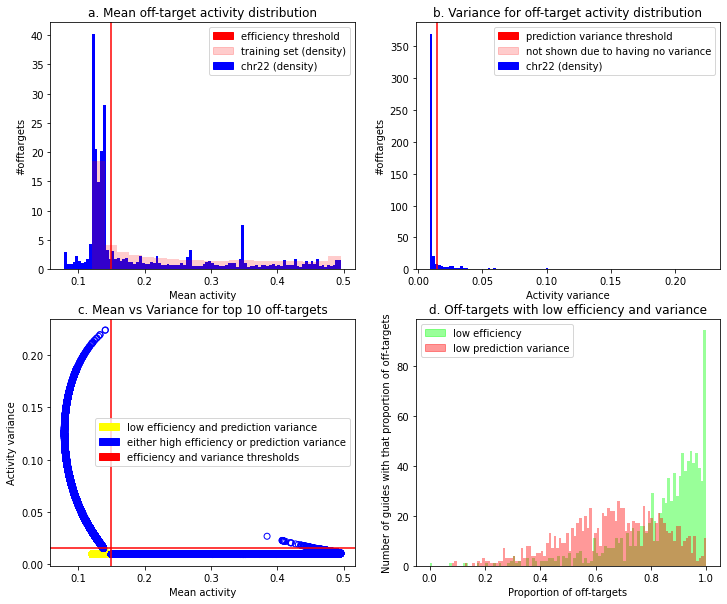

In [26]:
fig, ax = plt.subplots(2, 2)
ax[0][0].hist(total[8].values, density=True, bins=100, color="blue")
ax[0][0].hist(ko_w_oa, bins=20, density=True, color=(1,0,0,0.2))
ax[0][0].axvline(0.15, color="red")
ax[0][0].legend(
    handles=[
        Patch(color="red", label="efficiency threshold"), 
        Patch(color=(1,0,0,0.2), label="training set (density)"),
        Patch(color="blue", label="chr22 (density)")
    ]
)
ax[0][0].set_title("a. Mean off-target activity distribution")
ax[0][0].set_xlabel("Mean activity")
ax[0][0].set_ylabel("#offtargets")
ax[0][1].hist(total[9].values, bins=100, density=True, color="blue")
ax[0][1].legend(
    handles=[
        Patch(color="red", label="prediction variance threshold"), 
        Patch(color=(1,0,0,0.2), label="not shown due to having no variance"),
        Patch(color="blue", label="chr22 (density)")
    ]
)
ax[0][1].set_title("b. Variance for off-target activity distribution")
ax[0][1].set_xlabel("Activity variance")
ax[0][1].set_ylabel("#offtargets")
ax[0][1].axvline(0.015, color="red")
ax[1][0].scatter(
    total[8][np.logical_and(total[8]<0.15, total[9]<0.015)], 
    total[9][np.logical_and(total[8]<0.15, total[9]<0.015)],
    edgecolors="yellow", facecolors='none'
)
ax[1][0].scatter(
    total[8][np.logical_not(np.logical_and(total[8]<0.15, total[9]<0.015))], 
    total[9][np.logical_not(np.logical_and(total[8]<0.15, total[9]<0.015))],
    edgecolors="blue", facecolors='none'
)

ax[1][0].legend(
    handles=[
        Patch(color="yellow", label="low efficiency and prediction variance"), 
        Patch(color="blue", label="either high efficiency or prediction variance"),
        Patch(color="red", label="efficiency and variance thresholds"), 
    ]
)
ax[1][0].set_title("c. Mean vs Variance for top 10 off-targets")
ax[1][0].set_xlabel("Mean activity")
ax[1][0].set_ylabel("Activity variance")
ax[1][0].axvline(0.15, color="red")
ax[1][0].axhline(0.015, color="red")
ax[1][1].hist(offtarget_statistics["low efficiency"], bins=100, color=(0,1,0,0.4))
ax[1][1].hist(offtarget_statistics["low variance"], bins=100, color=(1,0,0,0.4))
ax[1][1].legend(
    handles=[
        Patch(color=(0,1,0,0.4), label="low efficiency"), 
        Patch(color=(1,0,0,0.4), label="low prediction variance")
    ]
)
ax[1][1].set_title("d. Off-targets with low efficiency and variance")
ax[1][1].set_xlabel("Proportion of off-targets")
ax[1][1].set_ylabel("Number of guides with that proportion of off-targets")

In [27]:
bu = offtarget_statistics[offtarget_statistics["high efficiency and variance"] > 0]

In [30]:
np.sum(bu["total"]*bu["high efficiency and variance"])

56.0

In [31]:
offtarget_statistics["total"].sum()

1994178